# Data Analysis

In [89]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn 

from wordcloud import WordCloud, STOPWORDS

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import warnings # suppressing waring for clustering
warnings.filterwarnings('ignore')

In [384]:
# load dataset
df = pd.read_csv("final_daft_listings.csv")

## Sentiment score

From the pre processed text, the overall sentiment of each description will be extracted and categorized by: positive, neutral or negative sentiment.

In [385]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [386]:
SIA = SentimentIntensityAnalyzer()

In [387]:
# function that extracts the compound score
def extract_compound(text): 
    score = SIA.polarity_scores(text)
    compound = score["compound"]
    return compound

In [388]:
df["Sentiment_score"] = df["Pre_processed_desc"].apply(lambda x: extract_compound(x))

the compound (sentiment score) is the normalized, weighted composite score
- positive sentiment : sentiment score >= 0.05
- neutral sentiment : (sentiment score > -0.05) & (sentiment score < 0.05)
- negative sentiment : sentiment score <= -0.05

Thus for easier understanding, a column representing the descriptions sentiment will be created.

In [389]:
def sentiment_threshold(sentiment_score): 
    if sentiment_score >= 0.05: 
        sentiment = "positive"
    elif (sentiment_score > -0.05) & (sentiment_score < 0.05): 
        sentiment = "neutral"
    else: 
        sentiment = "negative"
    return sentiment

df["Sentiment"] = df["Sentiment_score"].apply(lambda x: sentiment_threshold(x)) 

In [390]:
# How many positive, neutral and negative descriptions
df["Sentiment"].value_counts()

positive    1504
neutral      158
negative      67
Name: Sentiment, dtype: int64

Unsurprisingly, most daft listings are positive. Since these listings are ads to rent out rooms, the listings need to appear positive. Some are negative, which interesting to see, as negative descriptions would make readers shy away which is not the purpose of posting an ad.

### Are there differences in the distribution of sentiment descriptions between property types ? 

In [391]:
negative_desc = df[df["Sentiment"] == "negative"] # all rows with negative sentiment
positive_desc = df[df["Sentiment"] == "positive"] # all rows with positive sentiment
neutral_desc = df[df["Sentiment"] == "neutral"] # all rows with neutral sentiment

In [392]:
# how many counts for each property type
df["Property_type"].value_counts()

House        1403
Apartment     326
Name: Property_type, dtype: int64

##### number of listings about a room in a house with ...

In [393]:
# positive sentiment & house
print("positive sentiment: " + str(positive_desc["Property_type"].value_counts()[0]))

# neutral sentiment & house
print("neutral sentiment: " + str(neutral_desc["Property_type"].value_counts()[0]))

# negative sentiment & house
print("negative sentiment: " + str(negative_desc["Property_type"].value_counts()[0]))

positive sentiment: 1217
neutral sentiment: 130
negative sentiment: 56


Out of 1403 listings, 1217 listings have a positive description, 130 are neutral and 56 listings have a negative description.

##### number of listings about a room in an apartment with ...

In [394]:
# positive sentiment & apartment
print("positive sentiment: " + str(positive_desc["Property_type"].value_counts()[1]))

# neutral sentiment & apartment
print("neutral sentiment: " + str(neutral_desc["Property_type"].value_counts()[1]))
      
# negative sentiment & apartment
print("negative sentiment: " + str(negative_desc["Property_type"].value_counts()[1]))   

positive sentiment: 287
neutral sentiment: 28
negative sentiment: 11


Out of 326 listings, 287 listings have a positive description, 28 are neutral and 11 descriptions have a negative description.

##### Sentiment proportions by listing in houses vs apartments

Text(0.5, 1.05, 'apartments')

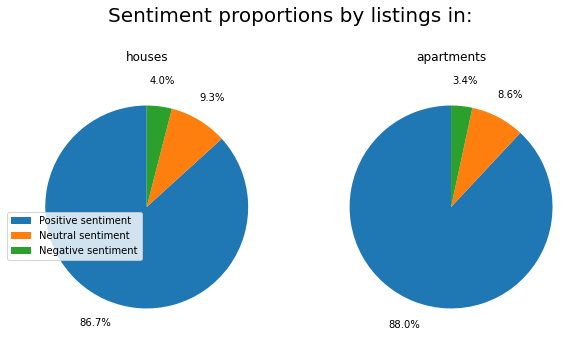

In [395]:
house_sentiment = np.array([positive_desc["Property_type"].value_counts()[0], neutral_desc["Property_type"].value_counts()[0],negative_desc["Property_type"].value_counts()[0]])
sentiment_labels = ["Positive sentiment", "Neutral sentiment", "Negative sentiment"]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,10))
plt.suptitle("Sentiment proportions by listings in:",y=0.78, size = 20)


ax1.pie(house_sentiment, startangle = 90, autopct='%1.1f%%',pctdistance=1.25, labeldistance=1.50)
ax1.legend( labels =sentiment_labels,loc='upper right', bbox_to_anchor=(0.5, 0.5), ncol = 1)
ax1.set_title('houses',y = 1.05)


house_sentiment = np.array([positive_desc["Property_type"].value_counts()[1], neutral_desc["Property_type"].value_counts()[1],negative_desc["Property_type"].value_counts()[1]])

ax2.pie(house_sentiment, startangle = 90, autopct='%1.1f%%',pctdistance=1.25, labeldistance=1.50)
#ax2.legend(labels =sentiment_labels,loc='upper right', bbox_to_anchor=(0.5, 0.5))
ax2.set_title('apartments',y = 1.05)


__Comparison of sentiment proportions by rooms in house and in apartments:__

The distribution within room listings in houses shows that positive descriptions make up to 86.7 % of all house listings. 9.3% are neutral and 4% are negative descriptions.
The distribution within room listings in aparment shows a similar picture. 88 % of the descriptions are positive, 8.6% are neutral and 3.4% are negative.
There are not significant differences in the distribution of positive, neutral and negative descriptions.

## Correlation heat map

in order to check the correlation between different variables, categorical variables will be converted into numerical variables by mapping numbers to each category.

##### function that automatically creates mapping dictionaries 

In [396]:
def dict_mapping(df, column): 
    list_of_unique_values = list(df[column].unique())
    my_dict = dict.fromkeys(list_of_unique_values)
    count = 0
    
    for i in list_of_unique_values:
        my_dict.update({i:count})
        count = count + 1
        
    return my_dict

In [397]:
# categorical variables -> numerical variables
df["Room_map"] = df["Room"].map(dict_mapping(df,"Room"))
df["Bath_map"] = df["Bath"].map(dict_mapping(df,"Bath"))
df["Property_type_map"] = df["Property_type"].map(dict_mapping(df,"Property_type"))
df["Owner_occupied_map"] = df["Owner_occupied"].map(dict_mapping(df,"Owner_occupied"))
df["Preferences_map"] = df["Preferences"].map(dict_mapping(df,"Preferences"))
df["County_map"] = df["County"].map(dict_mapping(df,"County"))

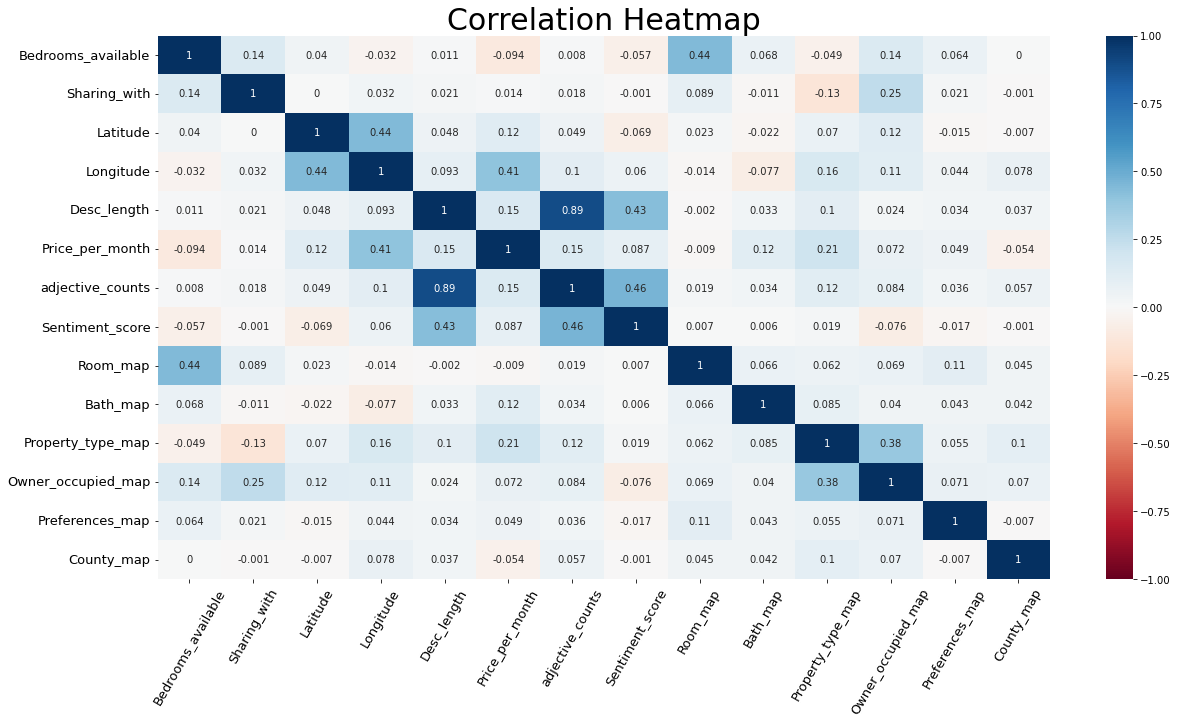

In [398]:
plt.figure(figsize=(20, 10))
corr_map = df.corr().round(3)
seaborn.heatmap(corr_map,vmin=-1, vmax=1, annot=True,cmap='RdBu')
plt.title("Correlation Heatmap", size = 30)
plt.xticks(rotation=60, size = 13)
plt.yticks(size = 13)
plt.show()

__Interesting points:__

*Relationships with medium effect*: 
    
    - rent price and rooms located along the latitude( 0.41) 
    - Room type and how many bedrooms are available (0.44)
    - sentiment of the description and the numbers of words used (0.43)
    - sentiment of the description and the number of adjectives used (0.46)
    
*Relationships with strong effect*: 
    
    - number of adjective used and the number of words used in the description have a very strong relationship with 0.89
    
(Based on this heatmap, one can only determine if certain variables are correlated to each other. But it cannot be determined which variable affects the other.
    
    

## WordClouds & Word frequencies

### Which words were used the most in daft listings (overall) ?

In [399]:
text = df["Pre_processed_desc"].str.cat()

In [400]:
def create_wordcloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show() 

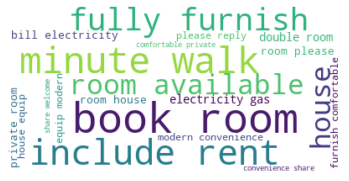

In [401]:
create_wordcloud(text)

In [402]:
text_dictionary = wordcloud.process_text(text)

# sort the dictionary
word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}

In [403]:
word_counts = list(word_freq.items()) # frequencies for each word

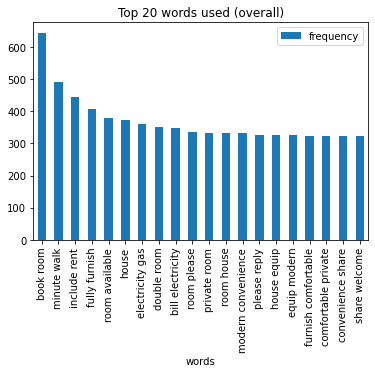

In [404]:
pd.DataFrame(word_counts[:20], columns=['words','frequency']).set_index('words').plot(kind='bar', title = "Top 20 words used (overall)");

Overall, the most frequent words used are "book room" with over 600 uses, "minute walk" with around 500 uses,"include rent" with around 450 uses and "fully furnish" with around 420 uses. 

- One can assume, that "minute walk" was used quite often, since a rooms location to amenities or certain buildings (workplace, university, ...) can be attractive factor users can take into consideration when looking for a room.
- The same goes for "include rent" which, assuming it means that the rent is included in the advertisement, can seem attractive. This is because when one is browsing through the listings, people click on listings with the assumption that the price listed on the advertisement includes all bills. From personal experience, I would not send an enquiry for a room, if the price listed has unforseen bills. It can come across like false advertisment. 
- "fully furnish" are also attractive words. This is because a fully furnished room is cheaper and less of a hassle for the person who will be renting the room because they do not have to purchase additional furniture.


### Wordclouds and top 20 word frequencies by sentiment

In [405]:
# function, that creates barplots for the top words used
def top_words(text, max_words, sentiment_text): 
    text_dictionary = wordcloud.process_text(text)
    
    # sort the dictionary
    word_freq={k: v for k, v in sorted(text_dictionary.items(),reverse=True, key=lambda item: item[1])}
    
    # list of word frequencies
    word_counts = list(word_freq.items())
    
    # word frequency plot
    pd.DataFrame(word_counts[:max_words], columns=['words','frequency']).set_index('words').plot(kind='bar', title = "Top " + str(max_words) + " words used on daft with " + str(sentiment_text));

In [406]:
# sort all text by their sentiment
text_pos = positive_desc["Pre_processed_desc"].str.cat()
text_neu = neutral_desc["Pre_processed_desc"].str.cat()
text_neg = negative_desc["Pre_processed_desc"].str.cat()

__by positive sentiment__

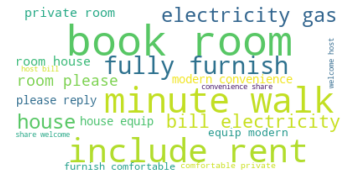

In [407]:
create_wordcloud(text_pos)

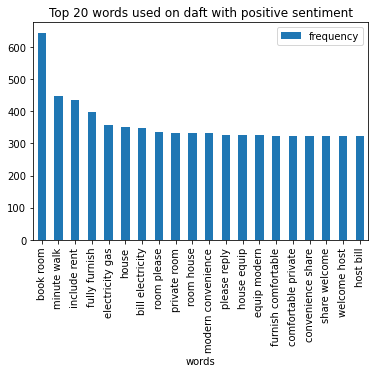

In [408]:
top_words(text_pos, 20, "positive sentiment")

like in the top 20 words used overall, the top 4 words: "book room", "minute walk","include rent" and "fully furnish" are the top 4 words used. Starting at the 5th and following words, they differ from the overall most popular used words.

__by neutral sentiment__

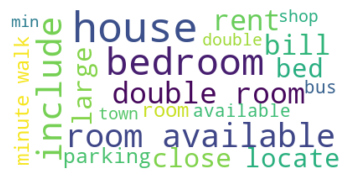

In [409]:
create_wordcloud(text_neu)

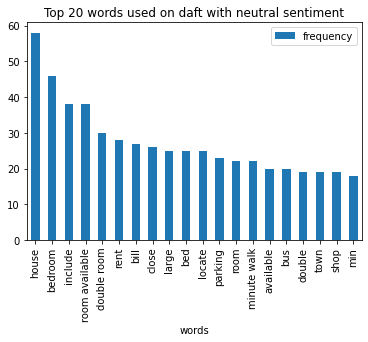

In [410]:
top_words(text_neu, 20, "neutral sentiment")

__by negative sentiment__

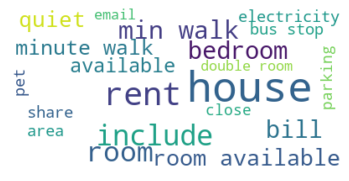

In [411]:
create_wordcloud(text_neg)

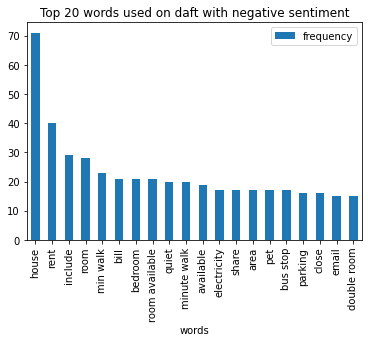

In [412]:
top_words(text_neg, 20, "negative sentiment")

The top first few words used with neutral or negative sentiment are not the same as the top words used overall/ with positive sentiment.

In [413]:
###

In [414]:
df_sort_County_Room = df.groupby(["County", "Room"], sort = True, as_index=False)["Address"].count()

In [415]:
df_sorted = df_sort_County_Room.rename(columns = {"Address":"Count"})

### Which county & room type has the most listings/ ads ?

In [416]:
df_sorted[df_sorted["Count"] == df_sorted["Count"].max()]

,County,Room,Count
12,Cork,Double Room,115


### Which counties & room type has the lowest amount of listings/ ads ? 

In [417]:
df_sorted[df_sorted["Count"] == df_sorted["Count"].min()]

,County,Room,Count
6,Cavan,Twin Room,1
8,Clare,"Double, Twin & Shared Room",1
9,Clare,Single & Double Room,1
11,Cork,Double & Shared Room,1
13,Cork,Shared Room,1
16,Cork,Twin Room,1
18,Donegal,Single & Double Room,1
19,Donegal,Single Room,1
20,Down,Single & Double Room,1
21,Dublin 1,Double & Shared Room,1


### Which room type is offered the most in Dublin ?

In [418]:
df_dublin =df_sorted[df_sorted['County'].str.contains("Dublin")] # df that only contains listings from Dublin

In [419]:
df_dublin[df_dublin["Count"] == df_dublin["Count"].max()]

,County,Room,Count
41,Dublin 15,Double Room,42


### Which room type in Dublin has the lowest amount of listings/ ads? 

In [420]:
df_dublin[df_dublin["Count"] == df_dublin["Count"].min()]

,County,Room,Count
21,Dublin 1,Double & Shared Room,1
24,Dublin 1,Single & Double Room,1
26,Dublin 1,Twin Room,1
29,Dublin 11,Twin Room,1
34,Dublin 13,Single & Double Room,1
36,Dublin 14,Double & Twin Room,1
38,Dublin 14,Single & Shared Room,1
44,Dublin 15,Twin Room,1
47,Dublin 16,"Single, Double & Twin Room",1
50,Dublin 17,Single Room,1


### Which county has the most & the least amount of listings/ ads ? 

In [421]:
df.groupby("County")["Address"].count().sort_values()

County
Fermanagh      1
Down           1
Antrim         2
Dublin 10      3
Dublin 17      5
Leitrim        7
Dublin 20      7
Offaly         7
Roscommon      9
Monaghan      10
Dublin 22     11
Dublin 11     12
Longford      12
Dublin 5      12
Cavan         14
Dublin 13     15
Donegal       17
Dublin 12     20
Sligo         20
Dublin 16     21
Mayo          21
Dublin 9      22
Dublin 2      22
Kilkenny      23
Laois         23
Dublin 4      26
Dublin 24     26
Dublin 1      28
Waterford     32
Kerry         32
Dublin 7      33
Westmeath     33
Carlow        33
Dublin 6      35
Dublin 14     35
Dublin 3      36
Dublin 18     38
Tipperary     38
Clare         39
Dublin 8      40
Wexford       45
Louth         56
Wicklow       56
Dublin 15     58
Meath         72
Limerick      78
Galway       107
Kildare      121
Cork         163
Name: Address, dtype: int64

Overall Cork has the most listings with 163, Fermananagh & Down have 1 each.

### which Dublin postal district has the most/ the least amount of listings/ ads? 

In [422]:
df_dublin.groupby("County")["Count"].count().sort_values()

County
Dublin 10    1
Dublin 11    2
Dublin 6     2
Dublin 5     2
Dublin 17    2
Dublin 18    2
Dublin 20    2
Dublin 12    3
Dublin 13    3
Dublin 4     3
Dublin 3     3
Dublin 22    3
Dublin 2     4
Dublin 9     4
Dublin 8     4
Dublin 16    4
Dublin 15    4
Dublin 24    4
Dublin 14    5
Dublin 7     5
Dublin 1     6
Name: Count, dtype: int64

<img src='dublin-districts-i2.jpg'> __Dublin postal districts__ </img>

Dublin 1 has the most with 6 listings. Dublin 10 has only 1 listing. 

## Price per month

<AxesSubplot:>

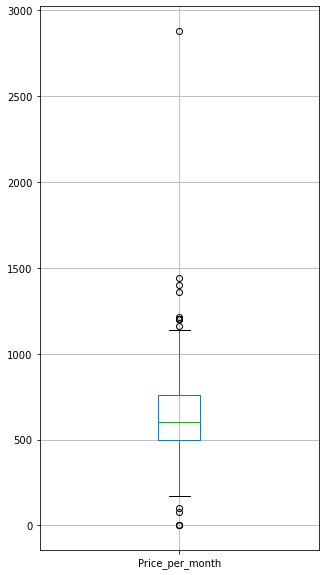

In [423]:
df.boxplot(column = "Price_per_month", figsize = (5,10))

In [424]:
df[df["Price_per_month"] == df["Price_per_month"].max()] # check suspicious outlier

,Address,Room,Bath,Property_type,Bedrooms_available,Available_from,Available_for,Sharing_with,Owner_occupied,Preferences,...,County,adjective_counts,Sentiment_score,Sentiment,Room_map,Bath_map,Property_type_map,Owner_occupied_map,Preferences_map,County_map
133,"OFF TANEY ROAD, Dundrum, Dublin 14",Double & Twin Room,Shared Bathroom,House,2,Immediately,1 Year,1,Yes,Male / Female,...,Dublin 14,5,0.7506,positive,6,0,0,0,0,20


There is a listing that advertises a room for 2880 Euro per month which is suspiciously high.

In [425]:
df["Price_per_month"].describe()

count    1518.000000
mean      636.041502
std       189.766224
min         1.000000
25%       500.000000
50%       600.000000
75%       760.000000
max      2880.000000
Name: Price_per_month, dtype: float64

In [426]:
df[df["Price_per_month"] == df["Price_per_month"].max()]["Price_per_month"]/4 # convert highest monthly rent back to weekly rent

133    720.0
Name: Price_per_month, dtype: float64

It is assumed, that the person who put the listing up might have mistakely put the monthly renting price as weekly renting price because when the price is converted back to weekly rent price, 720 Euros per month makes more sense than 2880 Euros per month. Therefore the rent for this listing will be adjusted accordingly.

In [427]:
df["Price_per_month"][df["Price_per_month"] == df["Price_per_month"].max()] = 720.0 # adjusting rent price

In [428]:
df.iloc[133] # adjusted listing

Address                                OFF TANEY ROAD, Dundrum, Dublin 14
Room                                                   Double & Twin Room
Bath                                                      Shared Bathroom
Property_type                                                       House
Bedrooms_available                                                      2
Available_from                                                Immediately
Available_for                                                      1 Year
Sharing_with                                                            1
Owner_occupied                                                        Yes
Preferences                                                 Male / Female
Date_entered/renewed                                           10/04/2023
Property_views                                                      4,848
Latitude                                                              NaN
Longitude                             

Looking at the updated boxplot and the summary for the rent price, it looks more realisitic.

<AxesSubplot:>

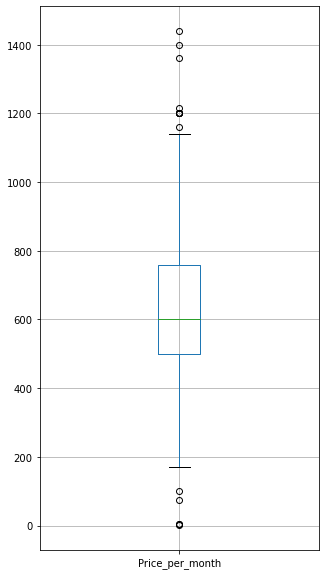

In [429]:
df.boxplot(column = "Price_per_month", figsize = (5,10))

In [430]:
df["Price_per_month"].describe()

count    1518.000000
mean      634.618577
std       180.816368
min         1.000000
25%       500.000000
50%       600.000000
75%       760.000000
max      1440.000000
Name: Price_per_month, dtype: float64

### Which listing has the highest renting price?

In [434]:
df[df["Price_per_month"] == df["Price_per_month"].max()]

,Address,Room,Bath,Property_type,Bedrooms_available,Available_from,Available_for,Sharing_with,Owner_occupied,Preferences,...,County,adjective_counts,Sentiment_score,Sentiment,Room_map,Bath_map,Property_type_map,Owner_occupied_map,Preferences_map,County_map
580,"38 Mountain View Drive, Dublin 14, Dublin 14",Twin Room,Shared Bathroom,House,1,"May 8th, 2023",3 Months,3,Yes,Female,...,Dublin 14,36,0.9918,positive,2,0,0,0,1,20


### Which listing has the lowest renting price?

In [380]:
df[df["Price_per_month"] == df["Price_per_month"].min()]

,Address,Room,Bath,Property_type,Bedrooms_available,Available_from,Available_for,Sharing_with,Owner_occupied,Preferences,...,adjective_counts,Sentiment_score,Sentiment,Room_map,Bath_map,Property_type_map,Owner_occupied_map,Preferences_map,County_map,"""Price_per_month"""
1024,"1 Crossmeadow, Kilconnib, Ferns, Enniscorthy, ...",Double Room,En-suite,House,1,Immediately,1 Year +,2,No,Male / Female,...,5,0.7693,positive,1,1,0,1,0,36,NaN


In [ ]:
###

In [467]:
# creates a list with bins
price_bins = [0] # 0 should be included in the bins or else a part of the data is lost
bin = int(df[df["Price_per_month"] == df["Price_per_month"].max()]["Price_per_month"]/5) # highest renting price divded by 5 to create 5 equally sized bins
sum = 0
for i in range(5): # loop to create bins
    sum = sum + bin
    price_bins.append(sum)

print(price_bins)

[0, 288, 576, 864, 1152, 1440]


In [464]:
df_bins = df.assign(bins = pd.cut(df["Price_per_month"], bins = price_bins)) # create column that bins based on renting price

In [465]:
df_bins_grp = df_bins.groupby(["bins", "County"], as_index=False)["Price_per_month"].count()
df_bins_grp = df_bins_grp.rename(columns = {"Price_per_month":"Count"})

In [491]:
df_bins_grp.groupby("County")["Count"].sum().sort_values()

County
Antrim         0
Down           0
Fermanagh      0
Dublin 10      2
Dublin 17      3
Dublin 20      6
Offaly         7
Leitrim        7
Roscommon      9
Dublin 5       9
Dublin 22     10
Dublin 11     10
Monaghan      10
Dublin 2      11
Dublin 13     11
Longford      12
Dublin 4      12
Dublin 1      13
Cavan         14
Dublin 9      16
Dublin 12     16
Donegal       17
Dublin 16     18
Sligo         20
Dublin 3      20
Dublin 24     21
Dublin 18     21
Mayo          21
Laois         23
Kilkenny      23
Dublin 6      23
Dublin 8      26
Dublin 14     27
Dublin 7      28
Waterford     32
Kerry         32
Westmeath     33
Carlow        33
Tipperary     38
Clare         39
Dublin 15     44
Wexford       45
Wicklow       52
Louth         56
Meath         72
Limerick      78
Galway       105
Kildare      116
Cork         154
Name: Count, dtype: int64

In [482]:
df_bins_grp.groupby("bins").barh()

AttributeError: 'DataFrameGroupBy' object has no attribute 'barh'

In [486]:
df.groupby(["County"], sort = True, as_index=False)["Price_per_month"].count().sort_values()

TypeError: sort_values() missing 1 required positional argument: 'by'